In [1]:
# Блокнот демонстрирует функционал использования класса PoseMultiple на примере кадов с рендера

In [2]:
# Импортирование модулей

In [1]:
import os, sys

In [2]:
base_dir = os.path.split(os.getcwd())[0]
os.chdir(os.path.join(base_dir))

In [3]:
import pickle as pk

import numpy as np
import cv2
import sys
import argparse
import time
import copy
import datetime
import yaml
from time import time

import matplotlib.pyplot as plt

from cranpose.utils import ARUCO_DICT, display_pose
from cranpose.estimators import PoseSingle, PoseMultiple, PoseSpecial

In [4]:
from scipy.spatial.transform import Rotation as R

In [5]:
# Создание экземпляра класса PoseSingle 

In [6]:
# путь к матрице калибровки
calibration_matrix_path = "calib/calibration_matrix_render_calib.npy"
# путь к коэффициентам дисторсии
distortion_coefficients_path = "calib/distortion_coefficients_render_calib.npy"
# длина стороны маркера в метрах
edge_len = 0.7
# шаг, с которым маркеры установлены
marker_step = 10
# максимальное число маркеров
n_markers = 100

# путь к конфигу с позициями маркеров
config_filename = "jupyters/marker_poses.yaml"

# загрузка конфига
with open(config_filename, encoding='utf8') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

# нам нужен дикт
marker_poses = dict(
    zip([id for id in range(len(cfg['poses']))], 
        cfg['poses']))

# тип маркеров (в проде будет "DICT_5X5_50" !!!)
type_ = "DICT_7X7_100"
if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)
aruco_dict_type = ARUCO_DICT[type_]

k = np.load(calibration_matrix_path)
d = np.load(distortion_coefficients_path)

# Создание двух сингл эстимэйторов

# Эстимэйтор для фронтальной камеры! 
estimator_front = PoseSingle(
    aruco_dict_type,
    1, # ориентация камеры: -1 для задней камеры, 1 для фронтальной !!!
    n_markers,
    marker_poses,
    edge_len,
    k,
    d)

# Эстимэйтор для задней камеры! 
estimator_rear = PoseSingle(
    aruco_dict_type,
    -1, # ориентация камеры: -1 для задней камеры, 1 для фронтальной !!!
    n_markers,
    marker_poses,
    edge_len,
    k,
    d)

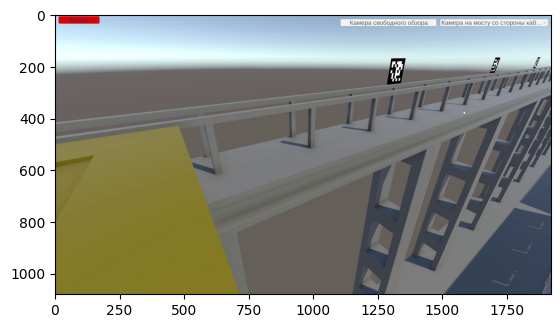

In [7]:
# Загрузка кадра с фронтальной камеры
image_front = 'demo_data/front.png'
image_front = cv2.imread(image_front)
plt.imshow(cv2.cvtColor(image_front, cv2.COLOR_BGR2RGB))
plt.show()

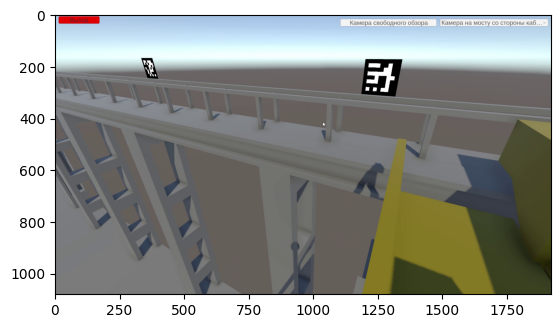

In [8]:
# Загрузка кадра с задней камеры
image_rear = 'demo_data/rear.png'
image_rear = cv2.imread(image_rear)
plt.imshow(cv2.cvtColor(image_rear, cv2.COLOR_BGR2RGB))
plt.show()

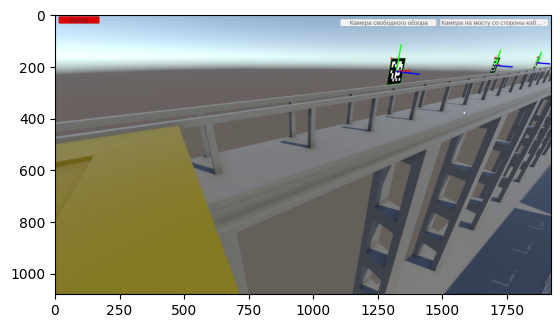

[[0.7927614092711787 -0.22418742896817764 0.5668062673109864 -6.517227596287206]
 [0.6084432362779477 0.3466162047985697 -0.7139005776707662 4.21901767680454]
 [-0.03641670218447185 0.9108222676591052 0.41118927580657205 -0.689691309653133]
 [0.0 0.0 0.0 1.0]]


In [9]:
frame, pose, size, is_moving = estimator_front(image_front, vis_movement=False, vis_detections=True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

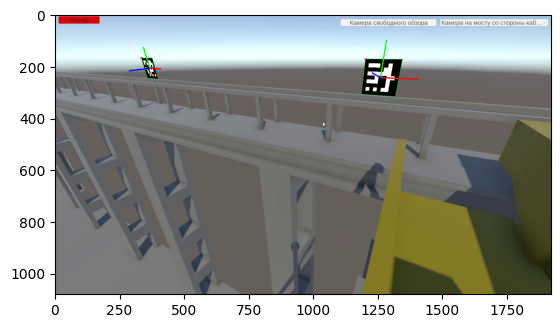

[[0.8703752567175389 0.18247354614752026 -0.4573295501607424 11.013734393334941]
 [-0.4860255890631984 0.16954269375030795 -0.8573414732600192 5.229893236042133]
 [-0.0789052550192263 0.9684826688961646 0.23625257835230662 0.42002764303112283]
 [0.0 0.0 0.0 1.0]]


In [10]:
frame, pose, size, is_moving = estimator_rear(image_rear, vis_movement=False, vis_detections=True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

In [11]:
# ФПС
t1 = time()
for _ in range(100):
    frame, pose, size, is_moving = estimator_rear(image_rear, vis_movement=False, vis_detections=True)
t2 = time()
print(t2-t1, 'sec, ', 100/(t2-t1), 'fps')

4.061392307281494 sec,  24.622098146173748 fps


In [14]:
# А вот так без отрисовки детекции на фрейме
t1 = time()
for _ in range(100):
    frame, pose, size, is_moving = estimator_rear(image_rear, vis_movement=False, vis_detections=False)
t2 = time()
print(t2-t1, 'sec, ', 100/(t2-t1), 'fps')

1.2448899745941162 sec,  80.3283840667156 fps


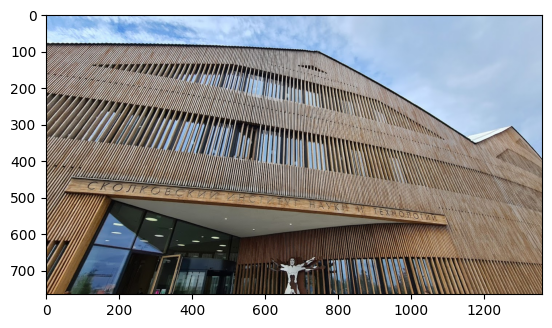

[[-- -- -- -6.186527449111787]
 [-- -- -- --]
 [-- -- -- --]
 [-- -- -- --]]


In [15]:
# Предсказание при отсутствии обнаружения маркеров
# Возвращаются ПОСЛЕДНИЕ КООРДИНАТЫ
frame, pose, size, is_moving = estimator_front(cv2.imread('demo_data/sk.jpg'), vis_movement=False, vis_detections=True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

In [16]:
# Создание экзмепляра класса PoseMultiple
estimator_mean = PoseMultiple(
    [estimator_front, estimator_rear])

In [17]:
# Случай, когда приходят два нона
estimator_mean([None, None])

masked_array(
  data=[[--, --, --, --],
        [--, --, --, --],
        [--, --, --, --],
        [--, --, --, --]],
  mask=[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float64)

In [18]:
# Случай, когда приходит один нон и нет предсказания на втором фрейме
estimator_mean([None, cv2.imread('demo_data/sk.jpg')])

masked_array(
  data=[[--, --, --, 0.0],
        [--, --, --, --],
        [--, --, --, --],
        [--, --, --, --]],
  mask=[[ True,  True,  True, False],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],
  fill_value=1e+20)

In [19]:
# Случай, когда приходит один нон и есть предсказание на втором фрейме
estimator_mean([None, image_rear])

masked_array(
  data=[[0.8702258729361412, 0.1826887147800928, -0.4575278828274067,
         10.490362157076323],
        [-0.4862879919946463, 0.16973056064807907, -0.8571554850923511,
         5.2250801405295055],
        [-0.07893616987380431, 0.9684091956781942, 0.23654325357440914,
         0.4176306524175973],
        [0.0, 0.0, 0.0, 1.0]],
  mask=[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],
  fill_value=1e+20)

In [20]:
# Случай, когда не предсказывает ни один эстимейтор
estimator_mean([cv2.imread('demo_data/sk.jpg'), cv2.imread('demo_data/sk.jpg')])

masked_array(
  data=[[--, --, --, 10.490362508580445],
        [--, --, --, --],
        [--, --, --, --],
        [--, --, --, --]],
  mask=[[ True,  True,  True, False],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],
  fill_value=1e+20)

In [21]:
# Случай, когда предсказывают не все эстимейторы
estimator_mean([cv2.imread('demo_data/sk.jpg'), image_rear])

masked_array(
  data=[[0.8702258729361412, 0.1826887147800928, -0.4575278828274067,
         10.746264200196011],
        [-0.4862879919946463, 0.16973056064807907, -0.8571554850923511,
         5.2250801405295055],
        [-0.07893616987380431, 0.9684091956781942, 0.23654325357440914,
         0.4176306524175973],
        [0.0, 0.0, 0.0, 1.0]],
  mask=[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],
  fill_value=1e+20)

In [22]:
# Случай, когда предсказывают все эстимейторы
estimator_mean([image_front, image_rear])

masked_array(
  data=[[0.8316255522400364, -0.020798529899475088, 0.05443513761736099,
         7.98960301618593],
        [0.06088186682304117, 0.2589675493143593, -0.7853082776406013,
         4.725766238307659],
        [-0.05806970502780673, 0.9393006017358485, 0.32452779510030405,
         -0.14304111709098802],
        [0.0, 0.0, 0.0, 1.0]],
  mask=[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],
  fill_value=1e+20)

In [23]:
# Кооридната X предсказания:
estimator_mean([image_front, image_rear])[0,3]

6.587818537494911

In [24]:
# Настройка фильра Калмана
multiple_estimator_kf = PoseMultiple(estimators=[
    estimator_front, estimator_rear],
    apply_kf=True,
    kf_transition_covariance=np.array([[1,1,1],
                                       [1,1,1],
                                       [1,1,1]]),   # этот массив 3 на 3
    kf_observation_covariance=np.array([1]))        # этот массив 1 на 1
# kf_transition_covariance и kf_observation_covariance имеют дефолтные значения.
# их можно также изменить в cranpose/default_config.yaml


In [25]:
# Настройка детекции двжиения камеры
from cranpose.cammovement import CameraMovement, AbsdiffComparison

estimator_with_movement = PoseSingle(
    aruco_dict_type,
    1,
    n_markers,
    marker_poses,
    edge_len,
    k,
    d,
    camera_movement=CameraMovement(AbsdiffComparison(4,4))
    )

===========> loading model <===========


/home/slava/cranpose/cranpose/estimators.py:123: UserWarning: 
                          Do not use vis_movement = True,
                          when calling the created object in production.
                          Use it only for debugging camera movement settings.
                          
  warnings.warn("""


In [26]:
# Специальный эстимейтор
# Special estimator

type_ = "DICT_5X5_50"

if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)

aruco_dict_type = ARUCO_DICT[type_]

special_estimator = PoseSpecial(
        aruco_dict_type = aruco_dict_type,
        marker_id = 38,
        marker_edge_len = 0.8,
        matrix_coefficients = k,
        distortion_coefficients = d,
        z_bias = 0,
        debug = False,
)

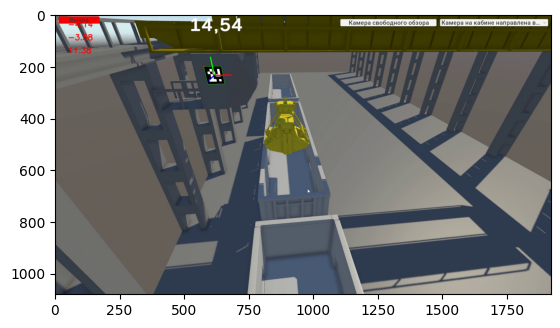

In [27]:
# Run on image
image_special = 'demo_data/special.png'

image_special = cv2.imread(image_special)

output, pose, is_moving = special_estimator(image_special, vis_movement=False, vis_detections=True)

output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

if pose.shape!=():
    output = display_pose(output, pose[:-1,[3]])
    
plt.imshow(output)
plt.show()

In [28]:
cv2.__version__

'4.8.1'